# Object Extraction
author: Andre Telfer    
email:  telfer006@gmail.com    
date:   2018-10-06    

## Description
This notebook was created to demonstrate object extraction from video feed

## Setup

In [5]:
import cv2              
import os

# load video
video_file = os.path.join(os.getcwd(), 'video_fish_A.avi')
cap = cv2.VideoCapture(video_file)
assert cap.isOpened(), "Error opening video file"

# get properties
frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

## Load Single Frame
Demonstrate loading a single frame

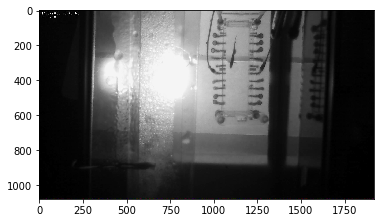

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

ret, frame = cap.read()
plt.imshow(frame)

## Background Subtraction using MOG2
Following the OpenCV [Background Subtraction Tutorial](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_video/py_bg_subtraction/py_bg_subtraction.html)

MOG2 creates adaptive Gaussian Mixture Models (GMMs) in order to subtract the background from real-time video feed

Two disadvantages of this method are
- MOG2 is adaptive, if the fish does not move then soon parts of it won't extracted
- MOG2 does not care what changes. When the fish moves, the area it left behind will have changed as well as the area it moves to. This will cause the centre of the data points to be dragged back

The OpenCV MOG2 implementation has an option for removing shadow. In some frames there does appear to be a shadow so it may seem useful, however using the default values the remove shadow option can delete the fish in frames with little movement.  

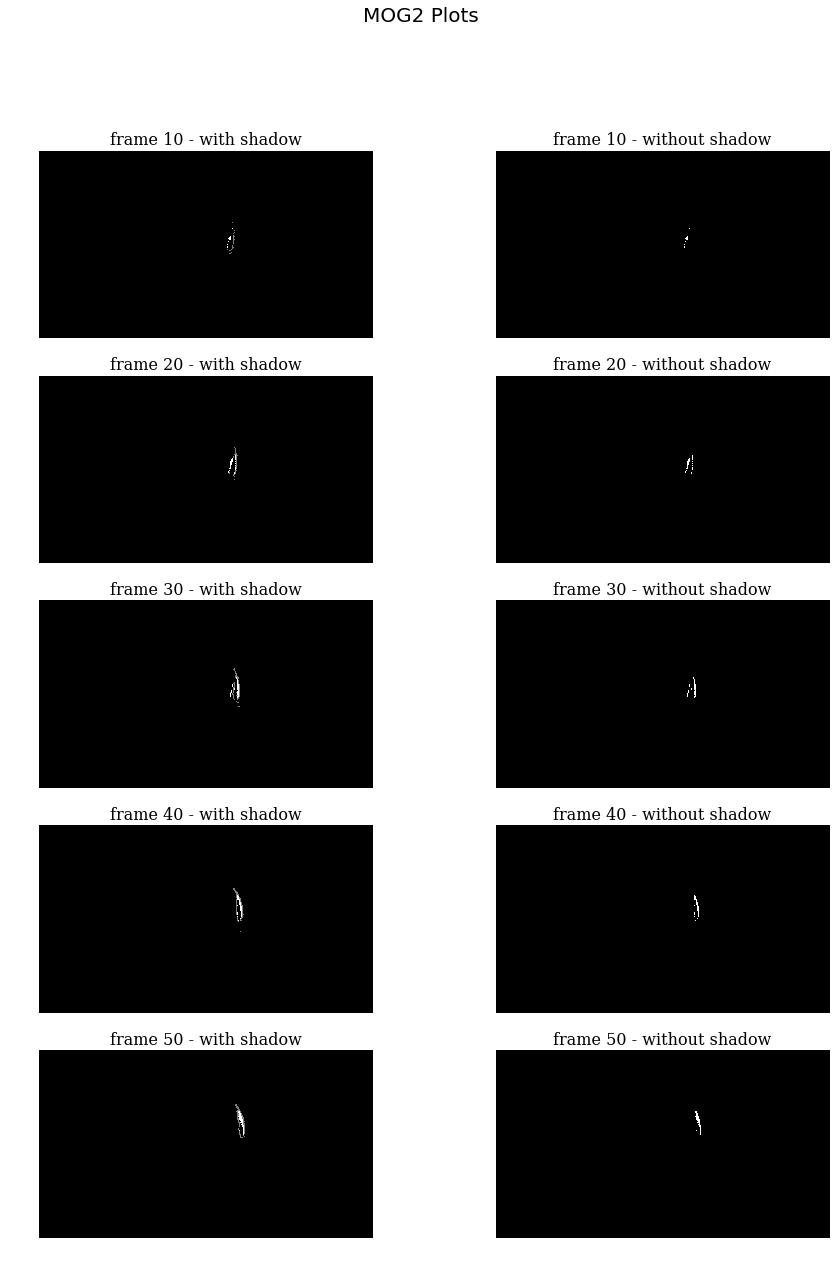

In [56]:
import numpy as np
import cv2

# setup the graph space
font = {
    'family': 'serif',
    'color':  'black',
    'weight': 'normal',
    'size': 16,
}
fig = plt.figure(figsize=(15,20))
fig.suptitle("MOG2 Plots", fontsize=20)

# initialize the background subtractor
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows=True)

for i in range(60):
    # load frame
    ret, frame = cap.read()
    
    # update the background subtractor
    fgmask = fgbg.apply(frame)
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
    
    # display every 10th frame, skip the first
    if i != 0 and i % 10 == 0:
        # plot MOG2
        rows = int(100 / 10 / 2) 
        cols = 2 
        index = 2*int(i / 10) - 1     
        plt.subplot(rows, cols, index)
        plt.imshow(fgmask, cmap='gray')
        plt.title('frame {} - with shadow'.format(i), font)
        plt.axis('off')
        
        # plot MOG2 without shadow
        index = 2*int(i / 10)  
        plt.subplot(rows, cols, index)
        plt.imshow(fgmask > fgbg.getShadowValue(), cmap='gray')
        plt.title('frame {} - without shadow'.format(i), font)
        plt.axis('off')

## Getting the Centre of the Fish
Following Krutika Bapat's tutorial on [finding the center of a blob](https://www.learnopencv.com/find-center-of-blob-centroid-using-opencv-cpp-python/).

This code finds the centroid by using the image moment, which is the value of the pixels modified by their intensity. Because we find the image moment to the MOG2 mask, there are only three pixel intensities: 255, 127, and 0. The 127 comes from what MOG2 determines to be the shadow

### Explanation
Image momement $ M_{ij}$ is found with:

$M_{ij} = \sum\limits_x\sum\limits_y x^i y^j I(x,y)$ 

Where $I(x,y)$ returns the intensity of a pixel at location $x$,$y$

This centroid using the image moment is 

$\large x_{center}=\frac{M_{10}}{M_{00}}$     

$\large y_{center}=\frac{M_{01}}{M_{00}}$

### Notes
- After some samples, the centroid fairly accurately targets the fish. However it moves around from the head to body

Text(0.5, 1.0, 'MOG2 Mask of Fish')

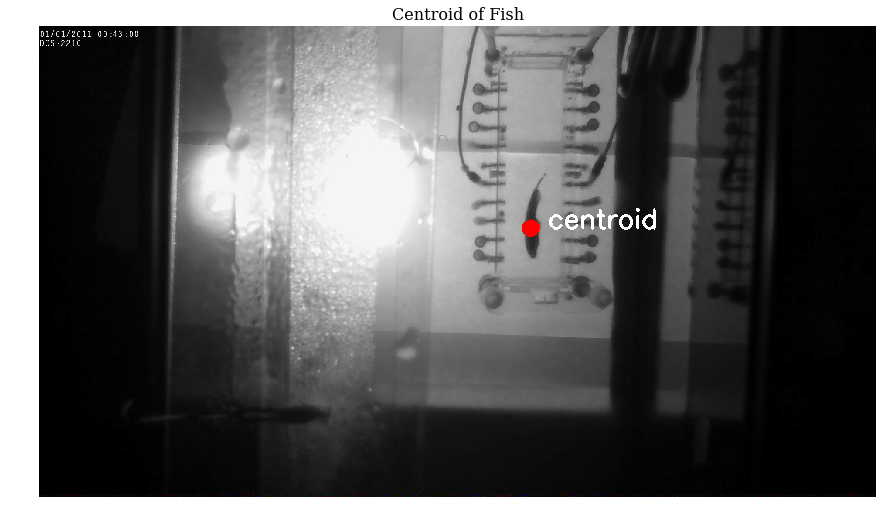

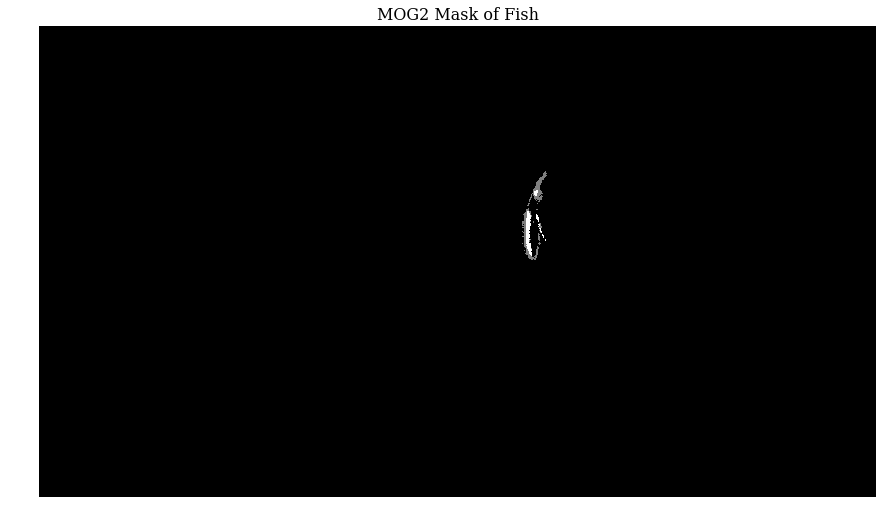

In [49]:
# load frame and apply the background subtractor
ret, img = cap.read()
fgmask = fgbg.apply(img)
fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)

# convert the grayscale image to binary image
ret,thresh = cv2.threshold(fgmask,127,255,0)
 
# calculate moments of binary image
M = cv2.moments(thresh)

# calculate x,y coordinate of center
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
 
# put text and highlight the center
cv2.circle(img, (cX, cY), 20, (255, 0, 0), -1)
cv2.putText(img, "centroid", (cX + 40, cY),cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 5)

# plot the image 
plt.figure(figsize=(15,10))
plt.imshow(img)
plt.title('Centroid of Fish', font)
plt.axis('off')

# plot the background subtraction mask
plt.figure(figsize=(15,10))
plt.imshow(fgmask, 'gray')
plt.axis('off')
plt.title('MOG2 Mask of Fish', font)